# camels script testing - topography attributes

In [1]:
%matplotlib inline  
import os, sys
import glob
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scripts.utility as util

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


## Reading MERIT topography

In [2]:
catchment_name = 'camels' #or camels
saveCSV = True
saveNetCDF = True

In [3]:
src_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/topography'
mapping_file = f'/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_loca2_600m_to_{catchment_name}.nc' 
#CONUS_HUC12
#gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg' 
# camels
gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg' #HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1.gpkg

In [4]:
# target catchment attribute
catch_attrs = {
    'CONUS_HUC12': ['HUCIDXint'],
    'camels': ['GAGE_ID']
}

In [5]:
# netcdf header: variable name
nc_var = {
    'dem':{'unit':'m','long_name':'mean altitude'},
    'slope':{'unit':'percent','long_name':'mean slope'},
    'easting':{'unit':'-','long_name':'mean eastness - sine of aspect: compass direction that a topographic slope faces, measured in degrees from north clockwise'},
    'northing':{'unit':'-','long_name':'mean northness - cosine of aspect: compass direction that a topographic slope faces, measured in degrees from north clockwise.'},
}

In [6]:
%%time
print(f'Reading dem data')
for ix, var in enumerate(nc_var.keys()):
    print(f'{ix} {var}')
    if ix==0:
        ds = xr.open_dataset(os.path.join(src_dir, f'MERIT_LOCA2_{var}_600m.nc')).load().rename({'Band1':var})
    else:
        ds = ds.merge(xr.open_dataset(os.path.join(src_dir, f'MERIT_LOCA2_{var}_600m.nc')).load().rename({'Band1':var}))
ds['slope'] = np.tan(ds['slope']*np.pi/360)
ds=ds.rename({
    'dem': 'elevation',
    'northing': 'northness',
    'easting': 'eastness'})

Reading dem data
0 dem
1 slope
2 easting
3 northing
CPU times: user 1.26 s, sys: 613 ms, total: 1.87 s
Wall time: 4.6 s


## Re-mapping
- Elevation [m], slope [m/m]

In [7]:
%%time
dr_mask = xr.where(np.isnan(ds['elevation']), 0, 1)
a = util.regrid_mean(xr.open_dataset(mapping_file), ds, dr_mask, ['elevation', 'slope', 'eastness', 'northness'])
a

Averaging 4 vriables for 671 polygons: 
-------------------
  averaged elevation
-------------------
  averaged slope
-------------------
  averaged eastness
-------------------
  averaged northness
CPU times: user 2.99 s, sys: 579 ms, total: 3.57 s
Wall time: 3.88 s


<xarray.Dataset> Size: 43kB
Dimensions:    (hru: 671)
Coordinates:
  * hru        (hru) <U8 21kB '01013500' '01022500' ... '09210500' '14158500'
Data variables:
    elevation  (hru) float64 5kB 276.1 98.93 173.7 ... 2.477e+03 1.258e+03
    slope      (hru) float64 5kB 0.03247 0.01823 0.01609 ... 0.07793 0.07661
    eastness   (hru) float64 5kB 0.02776 0.01592 0.03851 ... 0.1262 -0.1355
    northness  (hru) float64 5kB -0.06586 -0.09442 ... -0.06795 -0.08044

## Dataset to Dataframe

In [8]:
df = a.to_dataframe()

## Save in csv or netcdf

In [9]:
if saveCSV:
    df.to_csv(f'{catchment_name}_topo.csv', float_format='%g')
if saveNetCDF:
    a.to_netcdf(f'{catchment_name}_topo.nc')

## Plotting

In [10]:
gdf_camels = util.read_shps([gpkg],catch_attrs[catchment_name])

Finished reading /glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg


In [12]:
gdf_camels = gdf_camels.merge(df,left_on=catch_attrs[catchment_name], right_index=True)

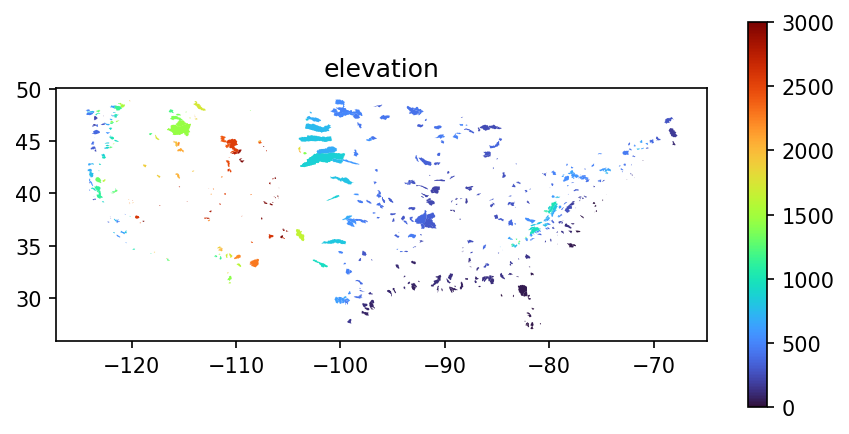

In [13]:
var_name = 'elevation'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 3000),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_topo_{var_name}.png', dpi=300)

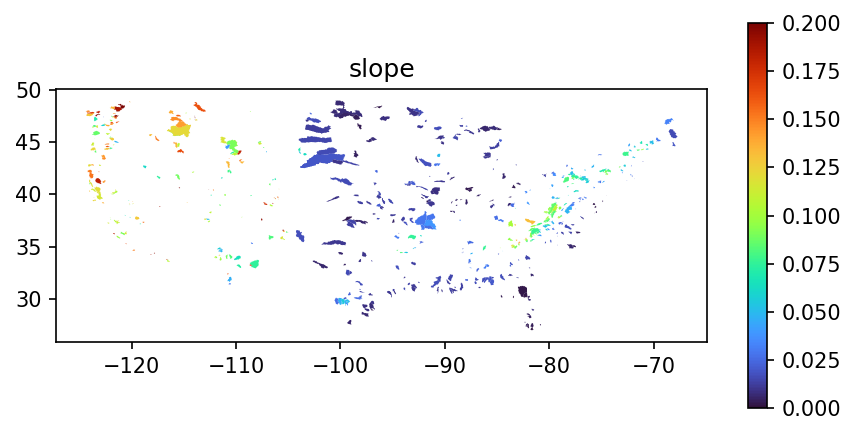

In [14]:
var_name = 'slope'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 0.2),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_topo_{var_name}.png', dpi=300)

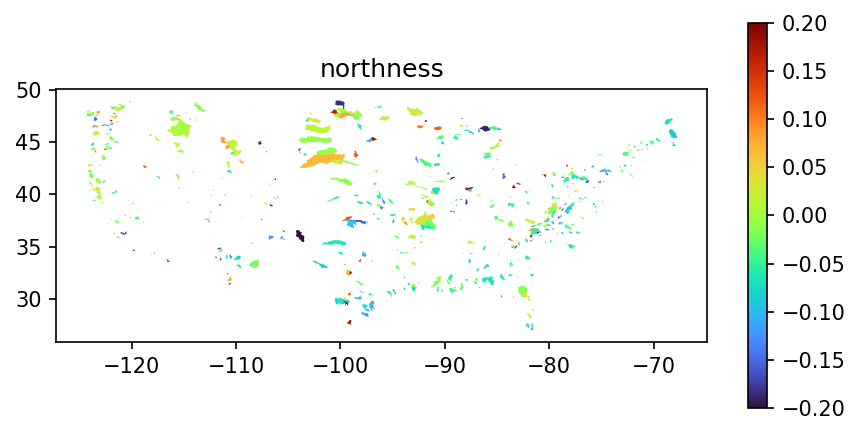

In [15]:
var_name = 'northness'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-0.2, 0.2),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_topo_{var_name}.png', dpi=300)

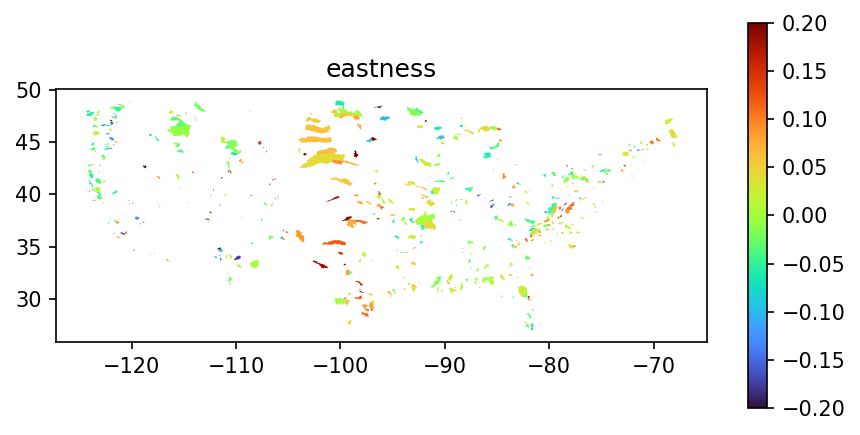

In [16]:
var_name = 'eastness'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-0.2, 0.2),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_topo_{var_name}.png', dpi=300)